<footer id="footer"></footer>

#  Прогнозирование заказов такси

![](https://i.ibb.co/qyGKjWw/taxi-550x400.jpg)  


Компания **«Чётенькое такси»** собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, **необходимо спрогнозировать количество заказов такси на следующий час**. 

---
<font size="1">
Примечание

*Значение метрики RMSE на тестовой выборке должно быть не больше 48*
</font>     


## Подготовка

### Загрузка необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style ('darkgrid')
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Загрузка данных и первичный осмотр

In [ ]:
!gdown --id 1eDFvhU1wrObJi-yt6P_75ZpEPcK3a6DR

Downloading...
From: https://drive.google.com/uc?id=1eDFvhU1wrObJi-yt6P_75ZpEPcK3a6DR
To: /content/taxi.csv
100% 600k/600k [00:00<00:00, 39.2MB/s]


In [ ]:
df = pd.read_csv('/content/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Количество заказов находится в столбце `num_orders`

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Перед нами стоит задача прогнозирования временного ряда, которая состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда  

Отсортируем наши времянные метки и проверим на монтонотонность

In [ ]:
df.sort_index(inplace=True)
df.index.is_monotonic

True

Пропусков нет, индекс монотонно возрастает, отсортирован - можем переходить к дальнейшей обработке данных

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Ресемплирование

Для начала посмотрим период, за который приведены данные

In [ ]:
max_date = df.index.max()
min_date = df.index.min()
print(f'Данные представлены за период c {min_date} по {max_date}')

Данные представлены за период c 2018-03-01 00:00:00 по 2018-08-31 23:50:00


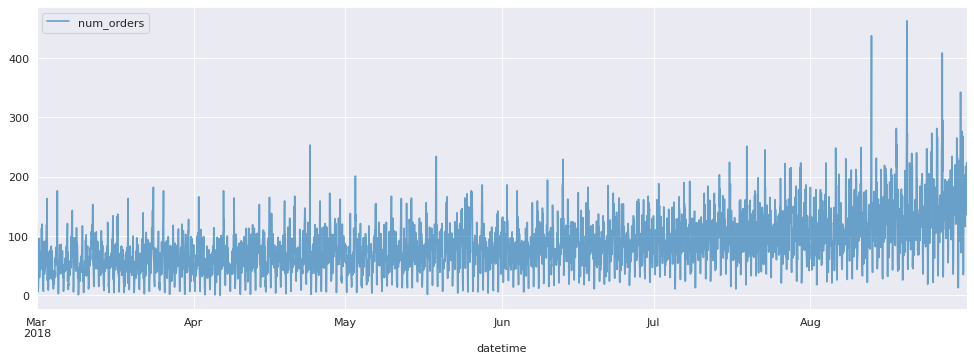

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)

# ресепмлирование сета, новый сет data

data = df.resample('1H').sum()
data.plot(ax=plt.gca(), alpha=.64)

plt.show()

Произвели ресемплирование - промежуток - 1 час, агрегацию проводили с помощью метода `sum()`

Можем переходить к анализу ряда

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Вывод

Провели первичный осмотр данных, сделали ресемплирование, можно переходить к анализу данных

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

## Анализ временного ряда
<a id='2.1'></a>

### Скользящее среднее


Применим скользящее среднее для сглаживание исходного ряда для выявления трендов. Попробуем два окна - дневной и недельный


Сгладим по дням, и посмотрим динамику, недельное сглаживание применим для отражения общих изменений

In [ ]:
def plot_ma(time_series, n):

    rolling_mean = time_series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))
    plt.title(f'Moving average\n размер окна = {n}')
    plt.plot(rolling_mean, "g", label="Тренд со скользящим средним")


    plt.plot(data[n:], label="Значения", alpha=.42)
    plt.legend(loc="upper left")
  

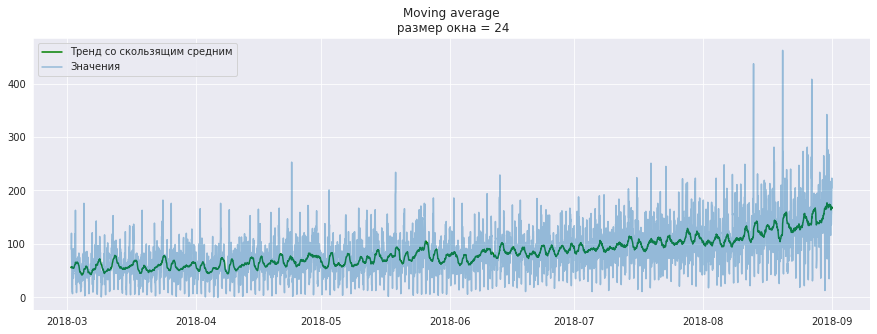

In [ ]:
plot_ma(data, 24)

[Яндекс.Такси](https://ru.wikipedia.org/wiki/%D0%AF%D0%BD%D0%B4%D0%B5%D0%BA%D1%81.%D0%A2%D0%B0%D0%BA%D1%81%D0%B8) основана в 2011 году, в июле 2017 года «Яндекс» и Uber подписали соглашение об объединении бизнеса и сервисов по онлайн-заказу такси в России и странах СНГ, таким образом тренд увеличения заказов больше связан с развитием самой компании, нежеле каким либо тенденциями, трендами или сезонностью. небольшие спады должно быть наблюдаются в ночное время, а также летом - в сезон отпусков, но с развитием сети и покрытием всей территории РФ и стран СНГ - данные показатели могут сглажены

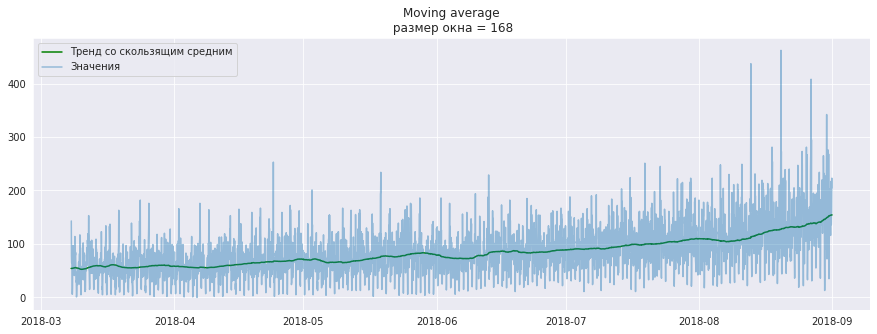

In [ ]:
plot_ma(data, 24*7)

Недельное окно показывает нам плавно восходящий тренд. Подтверждаем наше предположение о развитии сети

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Экспонициальное сглаживание

Воспользуемся [экспонициальным сглаживанием](https://ru.wikipedia.org/wiki/%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%81%D0%B3%D0%BB%D0%B0%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5). Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. То есть вместо использования окна постоянного размера, когда веса всех наблюдений одинаковы - зададим коэффициент затухания 

In [ ]:
def plot_ewm(time_series, span):

    rolling_mean = time_series.ewm(span).mean()

    plt.figure(figsize=(15,5))
    plt.title(f'Экспонициально взвешенное \n span = {span}')
    plt.plot(rolling_mean, "g", 
             label="Тренд с экспонициальнскользящим средним")


    plt.plot(data[span:], label="Значения", alpha=.42)
    plt.legend(loc="upper left")
  

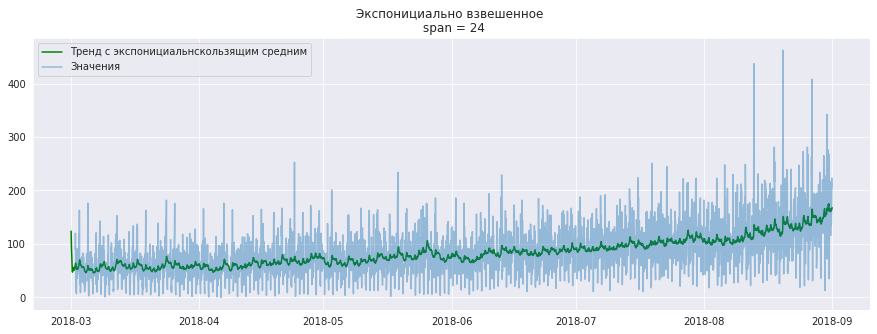

In [ ]:
plot_ewm(data, 24)

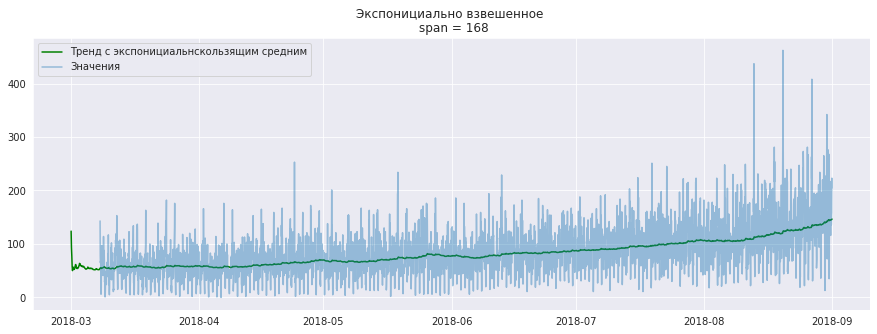

In [ ]:
plot_ewm(data, 24*7)

Результаты аналогичны [п. 2.1](#2.1)



### Разложение времянного ряда

Как мы видели, скорее всего сезонности мы не увидим, проверим данное предположение

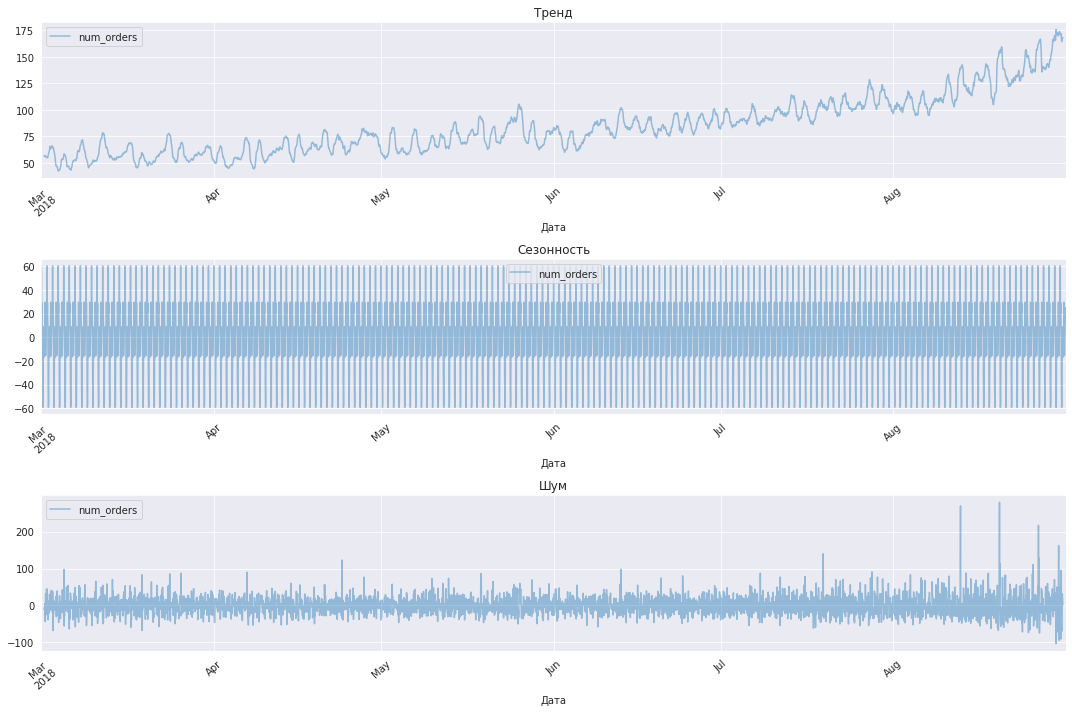

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), alpha=.42)
plt.title('Тренд')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=.42) 
plt.title('Сезонность')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), alpha=.42) 
plt.title('Шум')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.tight_layout()

Как и ожидалось, сезонности как таковой не наблюдается, тренд восходящий, для удобства посмотрим график сезонной составляющей на втором квартале и первой половине месяца, одном дне

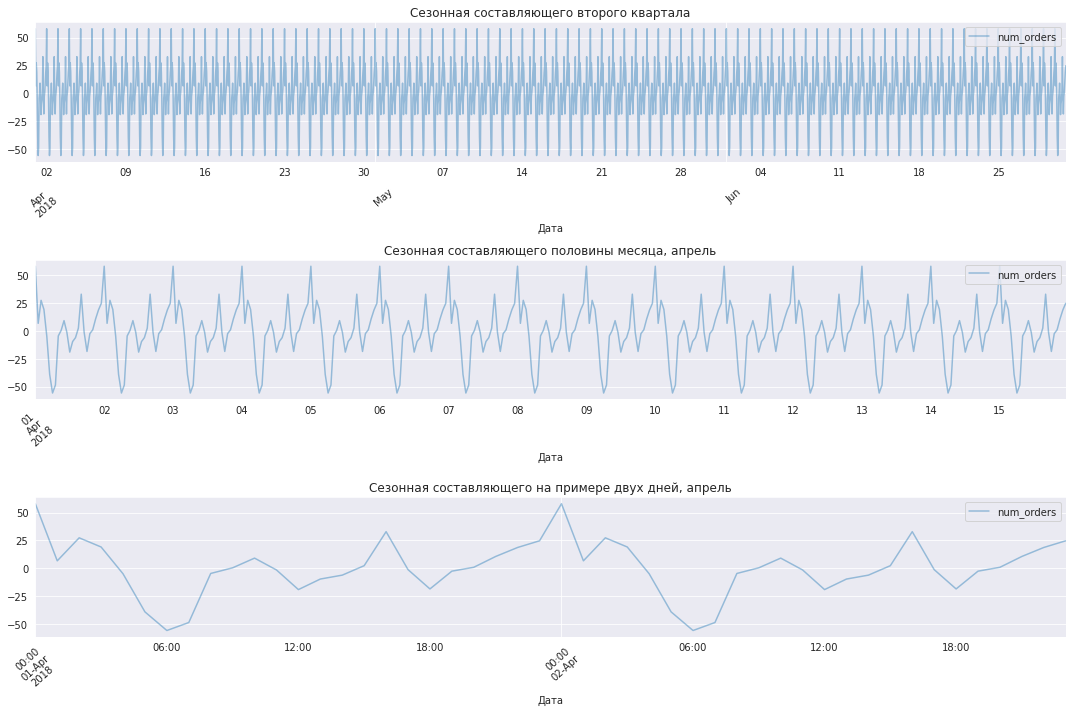

In [ ]:
plt.figure(figsize=(15, 10))
Q2 = data['2018-04':'2018-06']
decomposed = seasonal_decompose(Q2)

plt.subplot(311)
decomposed.seasonal['2018-04-01':'2018-06-30'].plot(ax=plt.gca(), alpha=.42)
plt.xlabel('Дата')
plt.xticks(rotation=42)
plt.title('Сезонная составляющего второго квартала')

plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca(), alpha=.42)
plt.title('Сезонная составляющего половины месяца, апрель')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(313)
decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca(), alpha=.42)
plt.title('Сезонная составляющего на примере двух дней, апрель')
plt.xticks(rotation=42)
plt.xlabel('Дата')


plt.tight_layout()

Сезонность привязана к времени суток, как видно, с полуночи наблюдается спад заказов, с 6 утра наблюдается рост, что связано с рабочими циклами пользователей услугой, как одна из причин

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Скользящее стандартное отклонение

Необходимо проверить наш ряд на стационарность

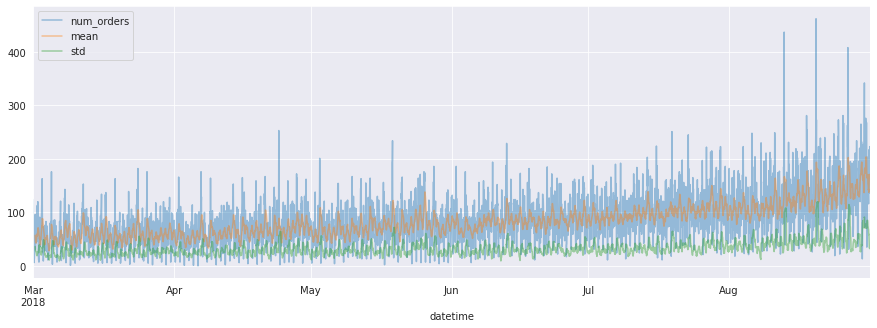

In [ ]:
plt.figure(figsize=(15, 5))
data['mean'] = data['num_orders'].rolling(12).mean()
data['std'] = data['num_orders'].rolling(12).std()
data.plot(ax=plt.gca(), alpha=.42) 
plt.show()

Наблюдаем незначительный рост стандартного отклонения, его колебания как и незначительный рост среднего. Посмотрим разницу ряда

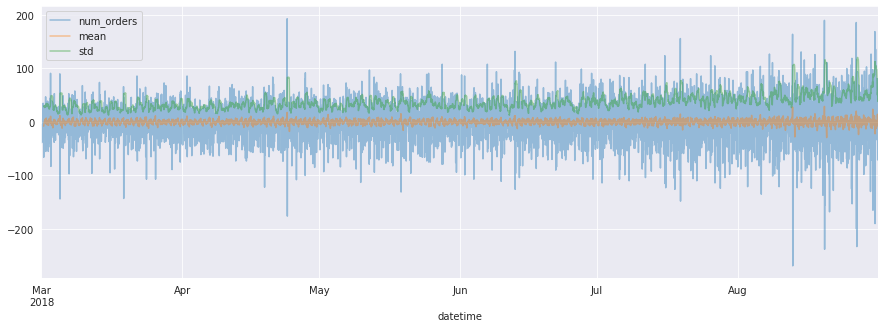

In [ ]:
data_shifted = data.copy()
plt.figure(figsize=(15, 5))
data_shifted['num_orders'] = data_shifted - data_shifted.shift()
data_shifted['mean'] = data_shifted['num_orders'].rolling(12).mean()
data_shifted['std'] = data_shifted['num_orders'].rolling(12).std()
data_shifted.plot(ax=plt.gca(), alpha=.42) 
plt.show()

Ряд стал более стационарным, удалим вспомогательные признаки, NaN и можно приступать к построению модели

In [ ]:
data = data.drop(['mean','std'], axis=1)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Вывод

Выявили сезонность связанную с веременем суток, посмотрели разницу ряда - после преобразования он стал более стационарным - значит данные можно прогнозировать

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

## Построение модели

### Подготовка признаков

Создадим дополнительные признаки и выделим целевой

In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

class AttributAdder():
    """класс для добавления артибутов. Порядок: Отстающие значения,
    размер окна, сет для преобразования"""

 
    def __init__(self, max_lag, rolling_mean_size):
        
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['year'] = X.index.year
        X['month'] = X.index.month
        X['day'] = X.index.day
        X['dayofweek'] = X.index.dayofweek
       
        for sma in range(5, self.rolling_mean_size + 1, 5):
            X[f'sma_{sma}'] = X['num_orders'].shift().rolling(
                window=sma).mean()
        
        
        for lag in range(1, self.max_lag + 1):
            X[f'lag_{lag}'] = X['num_orders'].shift(lag)
            
            
        return X   
    

In [ ]:
attr_adder = AttributAdder(28, 25)
features = attr_adder.transform(data)

In [ ]:
features.head()

,num_orders,year,month,day,dayofweek,sma_5,sma_10,sma_15,sma_20,sma_25,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train, test = train_test_split(features, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
X_train, y_train = split_data(train, 'num_orders')
X_test, y_test = split_data(test, 'num_orders')
X_train.shape, X_test.shape

((3946, 37), (442, 37))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Линейная регрессия

Создадим функцию для кросс-валидаци модели при обучении. Используем ее для Линейной регрессии. Для LightGBM воспользуемся CV

In [ ]:
def perform_time_seriesCV(X_train, y_train, number_folds, model, metrics):
    print('Размер обучающей выборки: {}'.format(X_train.shape))
        
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Размер обучабщего блока: {}'.format(k))

    errors = np.zeros(number_folds-1)
    
  
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Разбиение на первые ' + str(i) + ' куски ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Размер обучабщей выборки + тестовой: {}'.format(X.shape)) 

        index = int(np.floor(X.shape[0] * split))

       
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]


        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)**0.5

  
    return print(f'Средняя ошибка RMSE на валидации: {errors.mean()}')

In [ ]:
lr = LinearRegression(n_jobs=-1)
perform_time_seriesCV(X_train, y_train, 5, lr, mean_squared_error)

Размер обучающей выборки: (3946, 37)
Размер обучабщего блока: 789

Разбиение на первые 2 куски 1/2
Размер обучабщей выборки + тестовой: (1578, 37)

Разбиение на первые 3 куски 2/3
Размер обучабщей выборки + тестовой: (2367, 37)

Разбиение на первые 4 куски 3/4
Размер обучабщей выборки + тестовой: (3156, 37)

Разбиение на первые 5 куски 4/5
Размер обучабщей выборки + тестовой: (3945, 37)
Средняя ошибка RMSE на валидации: 26.815992578547828


In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

На кросс-валидации модель дает относительно незначительную ошибку RMSE. Проверим работу на тестовой выборке и сделаем выводы, но для начала построим еще одну модель на базе LGBM

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### LGBM

Построим модель на базе LGBM, проведем рандомный поиск параметров с кросс-валидаций на основе класса `TimeSeriesSplit`


In [ ]:

model = lgb.LGBMRegressor(boosting_type= 'gbdt', random_state=42
                         )
param_search = {'max_depth' : [20, 50], "n_estimators": [50, 100, 200],
               'learning_rate': [0.1, 0.25, 0.5]}

my_cv = TimeSeriesSplit(n_splits=6).split(X_train)

gsearch = RandomizedSearchCV(estimator=model, cv=my_cv,
                        param_distributions=param_search)
gsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f3f1ce41050>,
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None...m_state=42,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subs

In [ ]:
gsearch.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_model = gsearch.best_estimator_

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Тестирование

Создадим списки для отчетной таблицы

In [ ]:
scores = []
model_name = []

### Линейная регрессия

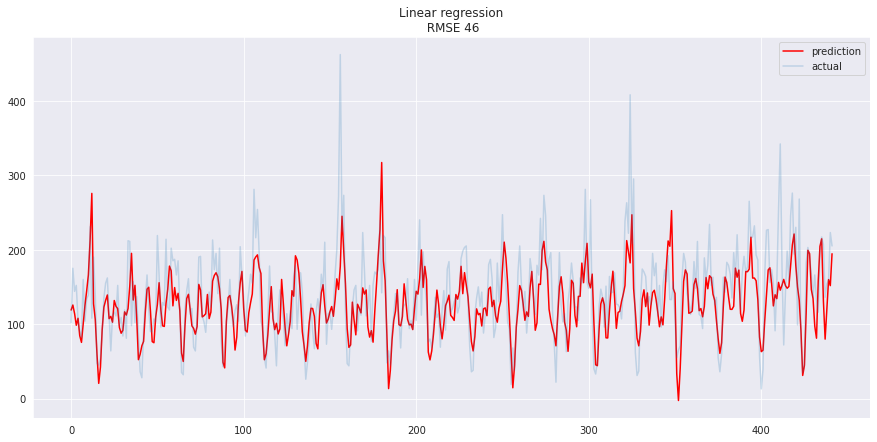

In [ ]:
prediction = lr.predict(X_test)
rmse_lr = mean_squared_error(prediction, y_test)**0.5
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual", alpha=.21)
plt.legend(loc="best")
plt.title("Linear regression\n RMSE {}".format(
    round(rmse_lr)))
plt.grid(True)

In [ ]:
scores.append(rmse_lr)
model_name.append(lr.__class__.__name__)

Результат лучше проходного. Посмотрим LGBM. У лучшей модели проведем анализ важности признаков

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### LGBM

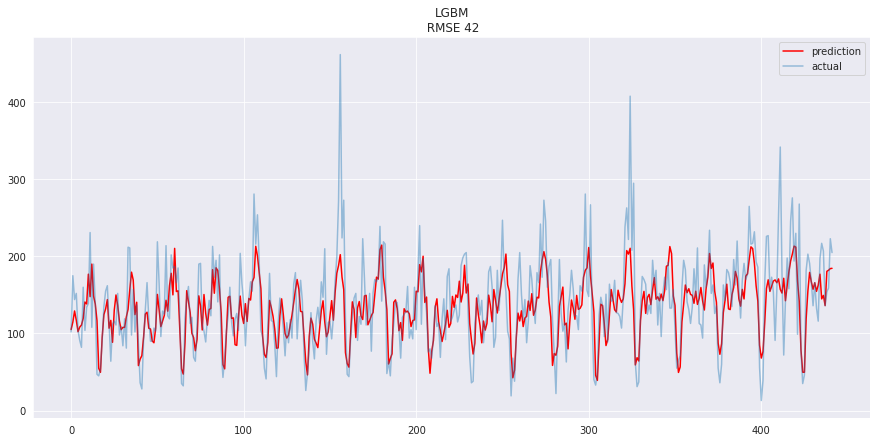

In [ ]:
prediction_lgbm = lgbm_model.predict(X_test)
lgbm_rmse = mean_squared_error(prediction_lgbm, y_test)**0.5
plt.figure(figsize=(15, 7))
plt.plot(prediction_lgbm, "r", label="prediction")
plt.plot(y_test.values, label="actual", alpha=.42)
plt.legend(loc="best")
plt.title("LGBM\n RMSE {}".format(
    round(lgbm_rmse)))
plt.grid(True)

In [ ]:
scores.append(lgbm_rmse)
model_name.append(lgbm_model.__class__.__name__)

У модели на базе LGBM метрика лучше, посмотрим какие признаки были важны:

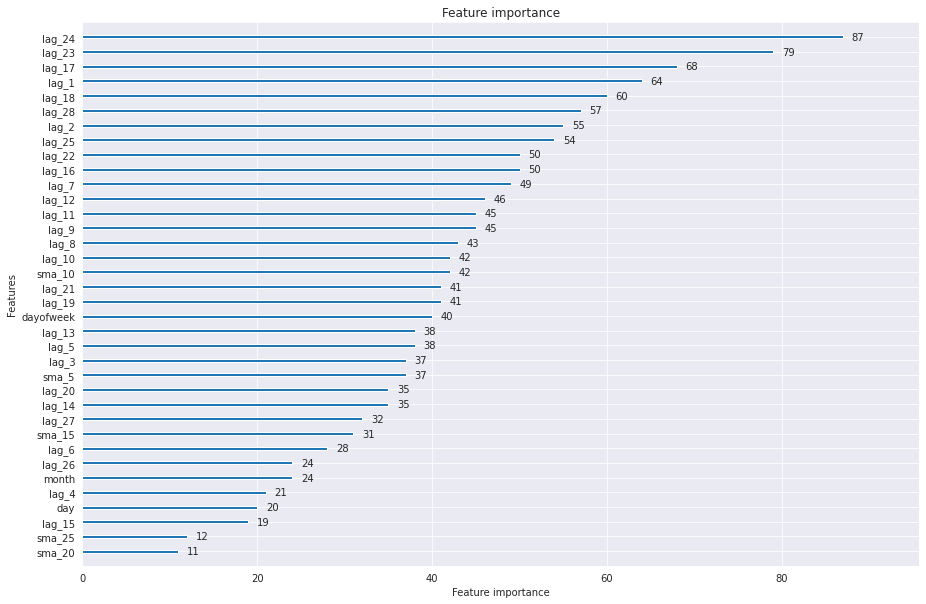

In [ ]:
lgb.plot_importance(lgbm_model, figsize = (15, 10))
plt.show()

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Качество прогноза (sanity check)

Предскажем ряд предыдущим значением. Селаем таким образом проверку на адекватность. RMSE должно бытьхуже, чем у наших моделей

In [ ]:
train_chk, test_chk = train_test_split(data, shuffle=False, test_size=0.1)
train_chk = train_chk.dropna()


pred_previous = test_chk.shift(periods=1, fill_value=train_chk['num_orders'].iloc[-1])
prev_rmse = mean_squared_error(test_chk, pred_previous)**0.5
print("Прогнозирование предыдущим значением ряда, RMSE:", 
      round(prev_rmse))


Прогнозирование предыдущим значением ряда, RMSE: 54


In [ ]:
scores.append(prev_rmse)
model_name.append('Previous_value')

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Вывод

In [ ]:
summary = pd.DataFrame(
    { 'model' : model_name , 'rmse' : scores }
    ).sort_values( by = 'rmse' ).reset_index( drop = True )
summary['approved'] = summary['rmse'].apply(lambda x: 'yes' if x <= 48 else 'not')
summary.style.highlight_min( 'rmse' , color = 'green' , axis = 0 )


,model,rmse,approved
0,LGBMRegressor,42.327443,yes
1,LinearRegression,46.487957,yes
2,Previous_value,54.064965,not


Нам было необходимо спрогнозировать количество заказов такси на следующий час и построить модель с метрикой RMSE выше 48. Для данных целей лучше всего подошла модель библиотеки LGBM.  

В процессе анализа были выяввлены дневные тренды:  

рост заказов с 6 утра и спад заказов с 23 часов

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>